# 앙상블 학습
### 보팅, 배깅
1. 보팅과 배깅의 공통점 : 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정.


2. 보팅과 배깅의 차이점
* 보팅 : 서로 다른 알고리즘을 가진 분류기를 결합.
* 배깅

    1. 각각의 분류기가 모두 같은 알고리즘이지만 데이터 샘플링을 서로 다르게 가져가며 학습을 수행하고 보팅을 수행.
    2. 대표적인 배깅 방식 : 랜덤 포레스트
    3. 부스트랩 방식으로 개별 Classifier에게 데이터를 샘플링.
    4. 교차 검증은 데이터 세트 간 중첩을 허용하지 않지만, 배깅 방식은 데이터 세트 간 중첩을 허용.

### 부스팅
1. 여러 개의 분류기가 순차적으로 학습을 수행.
2. 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에 가중치를 부여하는 방식.
3. 대표적인 부스팅 방식 : 그래디언트 부스트, XGBoost, LightGBM

### 스태킹
* 여러 가지 다른 모델의 예측 결과값을 다시 학습 데이터로 만들어 다른 모델(메타 모델)로 재학습시켜 결과를 예측

## 보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting)
* 하드 보팅 : 예측한 결과값들중 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정.


* 소프트 보팅 : 분류기들의 레이블 값 결정 확률의 평균을 구해 확률이 가장 높은 레이블 값을 결과값으로 선정. 일반적인 보팅 방법.

### 소프트 보팅 실습 : 위스콘신 유방암 데이터

In [15]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기 및 train, test set 설정

In [18]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(data = cancer.data, columns = cancer.feature_names)

X_train, X_test, y_train, y_test = train_test_split(cancer_df, cancer.target, test_size = 0.2, random_state = 157)

#### 보팅 분류기 설정 및 학습/예측/평가

In [19]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 8)
vo_clf = VotingClassifier(estimators = [('LR',lr_clf),('KNN',knn_clf)], voting='soft')

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(f'보팅 모델 정확도 : {accuracy:.4f}')

모델 정확도 : 0.9123


#### 개별 분류기 학습/예측/평가

In [21]:
for i in [lr_clf, knn_clf]:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    accuracy = accuracy_score(pred, y_test)
    print(f'{i} 모델 정확도 : {accuracy:.4f}')

LogisticRegression() 모델 정확도 : 0.9298
KNeighborsClassifier(n_neighbors=8) 모델 정확도 : 0.8860


## 랜덤 포레스트
* 부트스트랩 분할 방식으로 만들어진 서브세트에 결정 트리 분류기를 각각 적용하는 방식

### 랜덤 포레스트 실습 :  사용자 행동 인식 데이터
#### 데이터를 불러오기 위한 get_humn_dataset 함수

In [59]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
workspace_path = 'C:\\Users\\dbswj\\OneDrive\\바탕 화면\\human_activity'
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def get_new_feature_name_df(x):
    feature_dup_df = pd.DataFrame(data = x.groupby('column_name').cumcount(),columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(x.reset_index(), feature_dup_df, how = 'outer')

    for i in new_feature_name_df['index']:
        if new_feature_name_df.iloc[i,3] == 1:
            new_feature_name_df.iloc[i,2] = new_feature_name_df.iloc[i,2] + '_1'
        elif new_feature_name_df.iloc[i,3] == 2:
            new_feature_name_df.iloc[i,2] = new_feature_name_df.iloc[i,2] + '_2'
    # new_feature_name_df['column_name'] = new_feature_name_df['column_name','dup_cnt'].apply(lambda x: x[0] + '_' + x[1] if x[1] > 0 else x[0], axis = 1)    

    new_feature_name_df = new_feature_name_df.iloc[:,2].values.tolist()

    return new_feature_name_df

def get_human_dataset():
    data_path_train = os.path.join(workspace_path,'train')
    data_path_test = os.path.join(workspace_path,'test')
    feature_name_df = pd.read_csv(os.path.join(workspace_path,'features.txt'), sep = ' ', names = ['column_index','column_name'])
    feature_name = get_new_feature_name_df(feature_name_df)
    
    X_train = pd.read_csv(os.path.join(data_path_train,'X_train.txt'), sep = '\s+', names = feature_name)
    X_test = pd.read_csv(os.path.join(data_path_test,'X_test.txt'), sep = '\s+', names = feature_name)
    y_train = pd.read_csv(os.path.join(data_path_train,'y_train.txt'), sep = '\s+', names = ['action'])
    y_test = pd.read_csv(os.path.join(data_path_test,'y_test.txt'), sep = '\s+', names = ['action'])
    
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = get_human_dataset()

#### 랜덤 포레스트 학습/예측/평가

In [55]:
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 모델 정확도 : {accuracy:.4f}')

랜덤 포레스트 모델 정확도 : 0.9253


#### 하이퍼 파라미터 튜닝
* n_estimators : 결정 트리의 개수 지정, default = 10
* min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터 수 default = 2
* min_samples_leaf : 말단 노드가 되기 위한 최소한의 샘플 데이터 수 
* max_features : 최적의 분할을 위해 고려할 최대 피처 개수. default = sqrt(전체 피처 개수)

In [60]:
params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10 ,12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

print(f'모델 최고 예측 정확도 : {grid_cv.best_score_:.4f}')
print(f'최적 파라미터 : {grid_cv.best_params_}')

모델 최고 예측 정확도 : 0.9180
최적 파라미터 : {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


#### 최적 파라미터를 적용한 모델 설정

In [61]:
rf_clf1 = grid_cv.best_estimator_
rf_clf1.fit(X_train, y_train)
pred1 = rf_clf1.predict(X_test)
accuracy1 = accuracy_score(y_test, pred)
print(f' 테스트 세트 정확도 : {accuracy1:.4f}')

 테스트 세트 정확도 : 0.9253


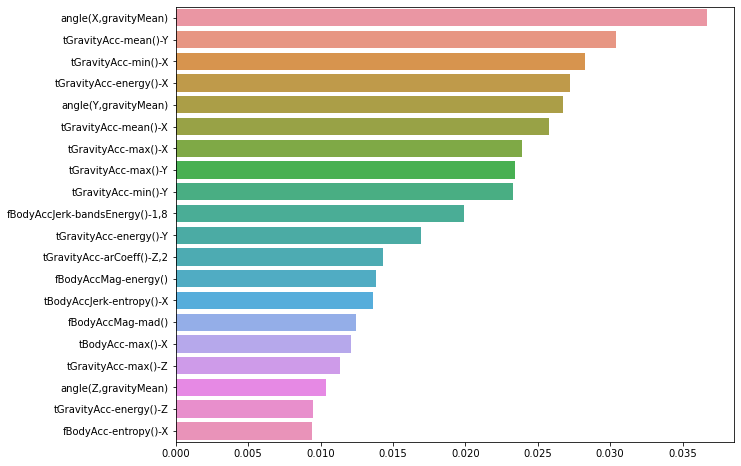

In [64]:
ftr_importance_values = rf_clf1.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(10,8))
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()